In [1]:
import numpy as np
import matplotlib.pyplot as plt

# K-means for image compression; choosing k

An image is a matrix of pixels. Each pixel can be represented as an array of RGB (red, green, blue) values. 

In most pictures, the RGB values in one pixel are likely to be similar to those in the pixels around it. For example, the below picture (from Wikimedia) has a lot of white pixels; even in the cat's fur, the grey and black tend to blend together.

![a cat](https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_March_2010-1.jpg)

If we can identify the common colors (the common RGB values) in a picture, then we can replace the RGB values for each pixel by just centroid RGB values. This in turn allows us to:
* compress the image - we can use the centroid IDs as the pixel's values, and just store the centroid RGB values in a dictionary
* segment the image into regions by color

To do this, we are going to treat the image itself as a dataset. Each row will correspond to a pixel, and the columns will be the RGB values.

## Let's do k-means on a picture!

In [2]:
# Most of this comes from day 22

# Let's define a distance metric; which one is this??
def distance(a, b):
    subtracted = a-b
    return np.sqrt(np.dot(subtracted.T, subtracted))

# Let's define a function to calculate the distance from each data point to each centroid
def get_distances(item, centroids):
    distances = [distance(item, centroid) for centroid in centroids]
    return distances

# Let's define a function to update cluster assignments given a set of centroids
def update_clusters(data, centroids):
    return [np.argmin(get_distances(item, centroids)) for item in data]

# Let's define a function to update the centroids
def update_centroids(data, clusters):
    with_clusters = np.hstack((data, np.array([clusters]).T))
    indices = np.argsort(with_clusters[:, -1])
    with_clusters_sorted = with_clusters[indices]
    by_cluster = np.array_split(with_clusters_sorted, np.where(np.diff(with_clusters_sorted[:, -1])!=0)[0]+1)
    return np.array([np.mean(cluster[:, :-1], axis=0) for cluster in by_cluster])

# Let's define a function to measure the inertia
def inertia(data, centroids, clusters):
    sum_squares = 0
    for i in range(len(data)):
        sum_squares += distance(data[i], centroids[clusters[i]])**2
    return sum_squares / len(data)

In [3]:
# We have to load the picture
from matplotlib.image import imread

image = imread('data/wikimedia_cat.jpg')
print(image.shape)

(69, 100, 3)


In [4]:
# We have to reshape it
data = image.reshape(image.shape[0]*image.shape[1], 3)
print(data.shape)

(6900, 3)


In [5]:
%%time

# We do k-means clustering for k from 2 to 16 to see what is a good value for k
# Watch how it takes longer and longer (both to converge, and to do one round) as k increases
inertia_by_k = []

for k in range(2, 17, 2):
    print(k)
    centroids = np.array([data[x] for x in np.random.choice(np.arange(len(data)), size=k, replace=False)])
    clusters = update_clusters(data, centroids)
    this_inertia = inertia(data, centroids, clusters)
    last_inertia = this_inertia + 1
    while abs(last_inertia - this_inertia) > 0.01:
        last_inertia = this_inertia
        centroids = update_centroids(data, clusters)
        clusters = update_clusters(data, centroids)
        this_inertia = inertia(data, centroids, clusters)
        print(this_inertia)
    inertia_by_k.append([k, this_inertia])


2
4780.57679404031
2045.2319513452858
2038.9501722259229
2038.8338006080382
2038.8094442312006
2038.8094442312006
4
4723.899026457096
2050.8515311932406
2039.0606856678367
2038.8338006080382
2038.8094442312006
2038.8094442312006
6
4730.764037177402
2049.177788301272
2039.0606856678367
2038.8338006080382
2038.8094442312006
2038.8094442312006
8
2312.2080374042057
430.3846236396789
308.69450118693885
259.362091441183
229.62360064117715
209.13459246364658
194.19134158101193
182.93465259783702
174.40276403607032
167.65216243289646
163.90664440544498
160.4322775900818
157.55486554610385
155.4118067938267
154.24712898460086
153.49463839308552
152.8853459898238
152.5647365945302
152.38910715373729
152.25829267273656
152.19756390785514
152.15608088489827
152.0611597919088
151.97604519161467
151.8609481088832
151.75845590949237
151.70722654645357
151.6554040733781
151.5999213509383
151.53621923280508
151.4228729747217
151.35409848628197
151.20439900488546
151.08358238856826
151.02356932876947
15

[[2.00000000e+00 2.03880944e+03]
 [4.00000000e+00 2.03880944e+03]
 [6.00000000e+00 2.03880944e+03]
 [8.00000000e+00 1.49932423e+02]
 [1.00000000e+01 1.49933388e+02]
 [1.20000000e+01 1.33302768e+02]
 [1.40000000e+01 1.00718169e+02]
 [1.60000000e+01 1.06810564e+02]]


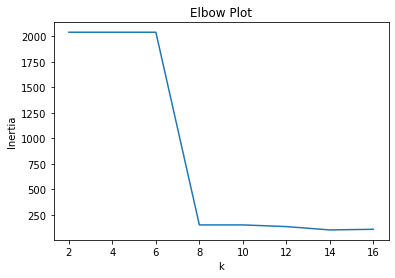

In [6]:
inertia_by_k = np.array(inertia_by_k)
print(inertia_by_k)
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)
ax1.plot(inertia_by_k[:, 0], inertia_by_k[:, 1])
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Plot')
plt.show()

## Let's replace each pixel in the picture with its corresponding centroid, and then display it!

In [7]:
def rebuild(centroids, clusters, input):
    # for each item in clusters add the corresponding centroid
    res = np.array([centroids[x] for x in clusters])
    print(res.shape, input.shape)
    # reshape
    res = res.reshape(input.shape[0], input.shape[1], input.shape[2])
    return res

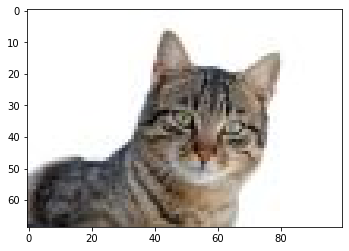

In [8]:
plt.imshow(image)

(6900, 3) (69, 100, 3)
(69, 100, 3)


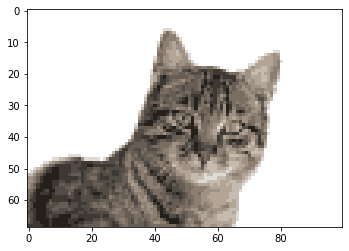

In [9]:
output = rebuild(centroids, clusters, image)
print(output.shape)
output = output.round().astype(int)
plt.imshow(output.round())

(425, 615, 3)
(261375, 3)


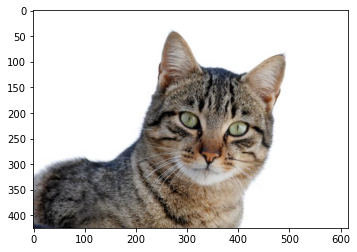

In [10]:
# Load the big version of the image
image = imread('data/wikimedia_cat_large.jpg')
print(image.shape)
plt.imshow(image)

# We have to reshape it
data = image.reshape(image.shape[0]*image.shape[1], 3)
print(data.shape)

In [11]:
%%time

# Do k-means with k=14; why 14?
k = 14

centroids = np.array([data[x] for x in np.random.choice(np.arange(len(data)), size=k, replace=False)])
clusters = update_clusters(data, centroids)
this_inertia = inertia(data, centroids, clusters)
last_inertia = this_inertia + 1
while abs(last_inertia - this_inertia) > 0.01:
    last_inertia = this_inertia
    centroids = update_centroids(data, clusters)
    clusters = update_clusters(data, centroids)
    this_inertia = inertia(data, centroids, clusters)
    print(this_inertia)

2521.5330479408376
553.6487330686313
346.8514568712579
290.4885541058174
262.98486936928623
248.0717360194446
237.75556025555468
229.02010208467874
222.14305708103163
217.764103190958
215.11053494441157
213.4253356761789
212.2918526761404
211.58606109417644
211.09845202896219
210.75042401097897
210.56675009987796
210.44056014394963
210.3460458081911
210.29221246953026
210.255744487772
210.23285360344116
210.20813273014846
210.18884820139579
210.17798378595054
210.1748604302019
Wall time: 4min 28s


(261375, 3) (425, 615, 3)
(425, 615, 3)


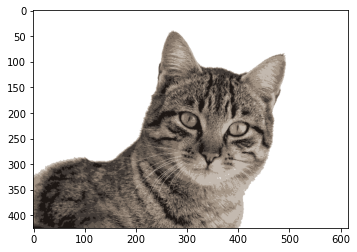

In [12]:
# Let's display the output!
output = rebuild(centroids, clusters, image)
print(output.shape)
output = output.round().astype(int)
plt.imshow(output.round())

# Question

If you replace each pixel in the above image with an integer (the index of the corresponding centroid), and keep the centroid dictionary, how much smaller is the picture size than the original?
* how many bytes to store each index?
* how many bytes to store each RGB triple? And how many triples per pixel? <- how many bytes per pixel?
* how many bytes per centroid?

In [13]:
261417 / 784125

0.3333868962219034

# K-means++

In addition to choosing the distance metric, and choosing $k$, we can change the way we initialize k-means. So far we've tried:
* random - what if it's the wrong random? Try several random initializations, take the best one
* get someone to label a little bit of the data to get an idea - what if the subset they label is not representative?

Now we will look at a third way. It goes like this:
1. Choose a single random data point as the first centroid, $\vec{c_1}$.
2. Repeat til $k$
  1. Calculate the distance between each data point $\vec{x_i}$ and its nearest previously chosen centroid $\vec{c_i}$.
  2. Pick the next centroid according to $p(\vec{x_i}) = \frac{d(\vec{x_i}, \vec{c_i})}{\sum_{j=1}^N d(\vec{x_j}, \vec{c_i})}$. (In python, you can get the index of this next centroid using index = np.random.choice([0, 1, ..., N], p=$p(x_i)$). You can also square the distances in the numerator and denominator above, to spread the distances out further.)

This means that we are more likely to choose a further away data point as the next centroid.


# Resources

* https://github.com/hanyoseob/python-k-means